In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from ipywidgets import interact, IntSlider, fixed
from IPython.display import display
from PIL import Image
from skimage.transform import resize
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE
import shap 
cudnn.benchmark = True
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import json

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch
from torchvision.models import resnet50
from torch.nn.functional import softmax
from PIL import Image
from torchvision import transforms

# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

model = nn.DataParallel(model)

import tensorflow as tf

def load_img(path):
    img = image.load_img(path, target_size=(224, 224, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def preprocess_to_tensor(img_array):
    # Remove the batch dimension and rearrange to [224, 224, 3]
    img_array = np.squeeze(img_array, axis=0)
    # Make a copy to ensure positive strides
    img_array = img_array.copy()
    # Convert to PyTorch tensor
    tensor = torch.from_numpy(img_array)
    # Permute the dimensions to [3, 224, 224]
    tensor = tensor.permute(2, 0, 1)
    # Add the batch dimension back: [1, 3, 224, 224]
    tensor = tensor.unsqueeze(0)
    return tensor

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
    
img_path = 'catdog.png'
img = read_tensor(img_path)

c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import torch
from torchvision.models import resnet50
from torch.nn.functional import softmax
from PIL import Image
from torchvision import transforms

img = read_tensor(img_path)

def predict_with_resnet50_pytorch(image_tensor, target_class=1):
    # Ensure the model is in evaluation mode
    model = resnet50(pretrained=True)
    model = model.eval()
    
    # Ensure the tensor is in the correct shape [C, H, W] with C=3, H=W=224
    # Check for batch dimension and add if missing
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        percentage = probabilities[0][target_class].item() * 100
        top_probabilities, top_classes = torch.topk(probabilities, k=3)
    # Convert output probabilities to softmax probabilities
    
    # Decode predictions to find the top 3 predictions
    return f'Prediction for class {target_class} = {percentage:.2f}%', top_probabilities[0], top_classes[0]

predicted_classes, top_probabilities, top_classes = predict_with_resnet50_pytorch(img)

# Assuming get_class_name is a function to get class names from class indices
# You'll need to define or import this function
print(predicted_classes)
for i in range(len(top_classes)):
    class_name = get_class_name(top_classes[i].item())
    percentage = top_probabilities[i].item() * 100
    print(f'Top {i+1} class: {class_name}, Probability: {percentage:.2f}%')

print(predicted_classes)
get_class_name(top_classes[0].item())

target_class = top_classes[0].item()


c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Prediction for class 1 = 0.00%
Top 1 class: bull mastiff, Probability: 38.42%
Top 2 class: tiger cat, Probability: 16.83%
Top 3 class: boxer, Probability: 9.41%
Prediction for class 1 = 0.00%


In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50
from torchvision import transforms

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class):
        # Ensure the model is in evaluation mode
        img_tensor = img_tensor.cuda()
        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            max_pred_score = probabilities[0][target_class].item() * 100  # Store the mutant number and percentage

        threshold = max_pred_score / 2
        print(f'Maximum prediction score: {max_pred_score}')
        print(f'Threshold: {threshold}')

        # Variables to store mutants
        sampled_tensor = torch.empty((N, *img_tensor.shape)).cuda()
        scores = []
        pass_count = 0
        fail_count = 0

        for i in range(N):
            is_pass = (i % 2 == 0 and pass_count < N // 2) or (i % 2 != 0 and fail_count >= N // 2)

            if is_pass:
                target_score = threshold
                tag = "Fail"
                fail_count += 1
            else:
                target_score = max_pred_score
                tag = "Pass"
                pass_count += 1

            found = False

            while not found:
                self.generate_masks(1, s, p1)
                masked_image = torch.mul(self.masks, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_score = probabilities[0][target_class].item() * 100

                if (tag == "Pass" and pred_score >= target_score) or (tag == "Fail" and pred_score < target_score):
                    found = True
                    best_score = pred_score
                    best_mutant = masked_image

            sampled_tensor[i] = best_mutant.squeeze(0)  # Remove the batch dimension
            scores.append(best_score)
        return sampled_tensor, scores

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))

# Assuming img_tensor is the image tensor in the correct shape [3, 224, 224]
# img_tensor = torch.randn(3, 224, 224)  # Replace with your actual image tensor
sampled_tensor, scores = explainer.generate_mutants(img, N=500, s=5, p1=0.4, target_class=target_class)
# Now `sampled_tensor` contains the N mutants

Maximum prediction score: 38.404858112335205
Threshold: 19.202429056167603


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


KeyboardInterrupt: 

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50
from torchvision import transforms

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            original_label = probabilities[0][0].item()
            original_label = get_class_name(original_label)
        print(f'Original label: {original_label}')
        
        sampled_tensor = torch.empty((N, *img_tensor.shape)).cuda()
        scores = []
        pass_count = 0
        fail_count = 0

        for i in range(N):
            is_pass = (i % 2 == 0 and pass_count < N // 2) or (i % 2 != 0 and fail_count >= N // 2)

            if is_pass:
                tag = "Pass"
                pass_count += 1
            else:
                tag = "Fail"
                fail_count += 1

            found = False

            while not found:
                self.generate_masks(1, s, p1)
                masked_image = torch.mul(self.masks, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_label = probabilities[0][0].item()
                    pred_label = get_class_name(pred_label)

                if (tag == "Pass" and pred_label == original_label) or (tag == "Fail" and pred_label != original_label):
                    found = True
                    best_mutant = masked_image

            sampled_tensor[i] = best_mutant.squeeze(0)  # Remove the batch dimension
            scores.append(pred_label)
        
        return sampled_tensor, scores

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))

# Assuming img_tensor is the image tensor in the correct shape [3, 224, 224]
# img_tensor = torch.randn(3, 224, 224)  # Replace with your actual image tensor
sampled_tensor, scores = explainer.generate_mutants(img, N=6, s=5, p1=0.4)
# Now `sampled_tensor` contains the N mutants

Class index: 6.6478010012360755e-06
Total classes: 1000


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50
from torchvision import transforms

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor.unsqueeze(0))
            probabilities = F.softmax(output, dim=1)
            original_label_idx = torch.argmax(probabilities, dim=1).item()
            original_label = get_class_name(original_label_idx)
        print(f'Original label: {original_label}')
        
        sampled_tensor = torch.empty((N, *img_tensor.shape)).cuda()
        scores = []
        pass_count = 0
        fail_count = 0

        for i in range(N):
            is_pass = (i % 2 == 0 and pass_count < N // 2) or (i % 2 != 0 and fail_count >= N // 2)

            if is_pass:
                tag = "Pass"
                pass_count += 1
            else:
                tag = "Fail"
                fail_count += 1

            found = False

            while not found:
                self.generate_masks(1, s, p1)
                masked_image = torch.mul(self.masks, img_tensor.unsqueeze(0))
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_label_idx = torch.argmax(probabilities, dim=1).item()
                    pred_label = get_class_name(pred_label_idx)

                if (tag == "Pass" and pred_label == original_label) or (tag == "Fail" and pred_label != original_label):
                    found = True
                    best_mutant = masked_image

            sampled_tensor[i] = best_mutant.squeeze(0)  # Remove the batch dimension
            scores.append(pred_label)
        
        return sampled_tensor, scores

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))

sampled_tensor, scores = explainer.generate_mutants(img, N=6, s=5, p1=0.4)
# Now `sampled_tensor` contains the N mutants


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 224, 224]

In [23]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50
from torchvision import transforms

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1):
        img_tensor = img_tensor.cuda()  
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            original_label_idx = torch.argmax(probabilities, dim=1).item()
            original_label = get_class_name(original_label_idx)
        print(f'Original label: {original_label}')
        
        sampled_tensor = torch.empty((N, *img_tensor.shape)).cuda()
        scores = []
        pass_count = 0
        fail_count = 0

        for i in range(N):
            is_pass = (i % 2 == 0 and pass_count < N // 2) or (i % 2 != 0 and fail_count >= N // 2)

            if is_pass:
                tag = "Pass"
                pass_count += 1
            else:
                tag = "Fail"
                fail_count += 1

            found = False

            while not found:
                self.generate_masks(1, s, p1)
                masked_image = torch.mul(self.masks, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_label_idx = torch.argmax(probabilities, dim=1).item()
                    pred_label = get_class_name(pred_label_idx)
                    pred_score = probabilities[0][pred_label_idx].item() * 100

                if (tag == "Pass" and pred_label == original_label) or (tag == "Fail" and pred_label != original_label):
                    found = True
                    best_mutant = masked_image

            sampled_tensor[i] = best_mutant.squeeze(0)  # Remove the batch dimension
            scores.append(pred_score)
        
        return sampled_tensor, scores


# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))


sampled_tensor, scores = explainer.generate_mutants(img, N=100, s=5, p1=0.4)
# Now `sampled_tensor` contains the N mutants


Class index: 243
Total classes: 1000
Original label: bull mastiff


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 333.28it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.64it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.38it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Class index: 281
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.64it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 169
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 661.98it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.63it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.36it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 996.51it/s]


Class index: 153
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 662.19it/s]


Class index: 155
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]

Class index: 208
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 399.23it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.32it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 176
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 259
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


Class index: 285
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


Class index: 285
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.88it/s]

Class index: 243
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 281
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 946.37it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 333.36it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 332.99it/s]

Class index: 254
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.16it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 208
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.32it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


Class index: 281
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.38it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 242
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.36it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]

Class index: 281
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


Class index: 155
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.64it/s]


Class index: 245
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 398.28it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]

Class index: 243
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.57it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 664.18it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 399.57it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.57it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.12it/s]

Class index: 243
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.68it/s]

Class index: 254
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 398.96it/s]

Class index: 285
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 665.66it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.39it/s]


Class index: 153
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 996.27it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Class index: 254
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 204
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 204
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 257
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 281
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]

Class index: 283
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 285
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Class index: 254
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


Class index: 799
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Class index: 254
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 663.76it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 254
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 203
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 891.65it/s]

Class index: 285
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 997.69it/s]


Class index: 257
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 486.75it/s]


Class index: 281
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.33it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 665.55it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 245
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 666.08it/s]

Class index: 282
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 285
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Class index: 204
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.41it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]

Class index: 281
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 204
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.36it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.33it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 493.10it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Class index: 155
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

Class index: 243
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 254
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.08it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]

Class index: 292
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]

Class index: 243
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Class index: 155
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 155
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 665.13it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Class index: 254
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]


Class index: 292
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]

Class index: 155
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]

Class index: 254
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.36it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 398.51it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]

Class index: 243
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

Class index: 254
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 998.41it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


Class index: 282
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 498.73it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


Class index: 154
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


Class index: 281
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 249.77it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]

Class index: 243
Total classes: 1000



Generating filters: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Class index: 243
Total classes: 1000


Generating filters: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]

Class index: 282
Total classes: 1000


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed
import torch  # Assuming the mutants tensor is a PyTorch tensor

def visualize_single_mutant(mutants, scores, index):
    """
    Visualize a single mutant image with its score.
    
    Parameters:
    - mutants: Tensor of mutant images.
    - scores: List or array of scores corresponding to the mutant images.
    - index: Index of the mutant image to visualize.
    """
    mutant_image = mutants[index].squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Squeeze and permute dimensions
    plt.figure(figsize=(5, 5))
    plt.imshow(mutant_image)
    plt.title(f"Mutant {index+1}\n{scores[index]:.2f}%")
    plt.axis('off')
    plt.show()

# Example tensor and scores (replace these with your actual data)


num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant, 
         mutants=fixed(sampled_tensor), 
         scores=fixed(scores), 
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));




interactive(children=(IntSlider(value=0, description='Mutant Index:', max=99), Output()), _dom_classes=('widge…

In [25]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
def unnormalize(tensor, mean, std):
    """
    Unnormalizes a tensor using the specified mean and std.
    """
    mean = torch.tensor(mean, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

def rgb_to_grayscale(tensor):
    """
    Converts RGB images to grayscale by applying the standard luminosity method.
    """
    r, g, b = tensor[:, 0, :, :], tensor[:, 1, :, :], tensor[:, 2, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Maintain the batch and channel dimension

sampled_tensor = TF.rgb_to_grayscale(sampled_tensor)
sampled_tensor.size()

torch.Size([100, 1, 1, 224, 224])

In [26]:
def calculate_relevance_scores(sampled_tensor ,scores, threshold=50, device='cuda'):

    # Move tensor to device
    sampled_tensor = torch.squeeze(sampled_tensor, dim=1)
    sampled_tensor = sampled_tensor.to(device)
    
    scores = torch.tensor(scores, device=device)
    mean = [0.485, 0.456, 0.406]  # ImageNet mean
    std = [0.229, 0.224, 0.225]   # ImageNet std
    sampled_tensor = unnormalize(sampled_tensor, mean, std)
    # Determine the dimensions of the images
    _, C, H, W = sampled_tensor.shape
    
    # Initialize the counters for each pixel
    Ep = torch.zeros((H, W), dtype=torch.float, device=device)
    Np = torch.zeros((H, W), dtype=torch.float, device=device)
    Ef = torch.zeros((H, W), dtype=torch.float, device=device)
    Nf = torch.zeros((H, W), dtype=torch.float, device=device)
    
    # Calculate the masks for the conditions
    executed_mask = sampled_tensor.sum(dim=1) != 0  # Pixel executed if any channel is non-zero
    passed_mask = scores > threshold  # Prediction passed
    failed_mask = scores <= threshold  # Prediction failed
    
    # Iterate over each image and update the counters
    for i in range(sampled_tensor.shape[0]):
        current_image = sampled_tensor[i]
        current_executed_mask = executed_mask[i].float()
        
        if passed_mask[i]:
            Ep += current_image.sum(dim=0) * current_executed_mask.float()
            Np = 500 - Ep
        else:
            Ef += current_image.sum(dim=0) * current_executed_mask.float()
            Nf = 500 - Ef
        
        # Debugging print statements
        print(f"Mutant {i}: Score = {scores[i].item()}")
        print(f"Executed Mask Sum = {current_executed_mask.sum().item()}")
        print(f"Current Image Sum = {current_image.sum(dim=0).sum().item()}")
        print(f"Ep Sum = {Ep.sum().item()}")
        print(f"Np Sum = {Np.sum().item()}")
        print(f"Ef Sum = {Ef.sum().item()}")
        print(f"Nf Sum = {Nf.sum().item()}")
    Ep = Ep/2
    Ef = Ef/2
    Np = 250 - Ep
    Nf = 250 - Ef
    # Calculate the relevance scores
    relevance_scores = torch.zeros((H, W, 4), dtype=torch.float, device=device)
    relevance_scores[:, :, 0] = Ep
    relevance_scores[:, :, 1] = Np
    relevance_scores[:, :, 2] = Ef
    relevance_scores[:, :, 3] = Nf
    
    return relevance_scores

relevance_scores = calculate_relevance_scores(sampled_tensor, scores)

# Convert relevance_scores to a readable format
relevance_scores_np = relevance_scores.cpu().numpy()

# Flatten the H and W dimensions to make it easier to print
H, W, _ = relevance_scores_np.shape
flattened_scores = relevance_scores_np.reshape(H * W, 4)

# Print the first 1000 pixels
for i in range(min(1000, flattened_scores.shape[0])):
    Ep, Np, Ef, Nf = flattened_scores[i]
    print(f'Pixel {i}: Ep={Ep:.4f}, Np={Np:.4f}, Ef={Ef:.4f}, Nf={Nf:.4f}')

Mutant 0: Score = 54.640167236328125
Executed Mask Sum = 50176.0
Current Image Sum = 70029.234375
Ep Sum = 70029.234375
Np Sum = 25017972.0
Ef Sum = 0.0
Nf Sum = 0.0
Mutant 1: Score = 43.86669158935547
Executed Mask Sum = 50176.0
Current Image Sum = 65604.203125
Ep Sum = 70029.234375
Np Sum = 25017972.0
Ef Sum = 65604.203125
Nf Sum = 25022396.0
Mutant 2: Score = 87.54977416992188
Executed Mask Sum = 50176.0
Current Image Sum = 69215.875
Ep Sum = 139245.109375
Np Sum = 24948754.0
Ef Sum = 65604.203125
Nf Sum = 25022396.0
Mutant 3: Score = 56.35126876831055
Executed Mask Sum = 50176.0
Current Image Sum = 65558.28125
Ep Sum = 204803.390625
Np Sum = 24883196.0
Ef Sum = 65604.203125
Nf Sum = 25022396.0
Mutant 4: Score = 59.1491584777832
Executed Mask Sum = 50176.0
Current Image Sum = 64550.6015625
Ep Sum = 269354.0
Np Sum = 24818646.0
Ef Sum = 65604.203125
Nf Sum = 25022396.0
Mutant 5: Score = 35.445011138916016
Executed Mask Sum = 50176.0
Current Image Sum = 66400.5390625
Ep Sum = 269354.0

In [27]:
def calculate_ochiai(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef / np.sqrt((Ef + Nf) * (Ef + Ep))

def calculate_tarantula(pixel):
    Ep, Np, Ef, Nf = pixel
    return (Ef/(Ef + Nf)) / ((Ef/(Ef + Nf)) + (Ep/(Ep + Np)))

def calculate_zoltar(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef/(Ef + Nf + Ep + ((10000*Nf*Ep)/Ef))  

def calculate_wong1(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef - Ep

ochiai_scores = np.array([calculate_ochiai(pixel) for pixel in flattened_scores])
tarauntula_scores = np.array([calculate_tarantula(pixel) for pixel in flattened_scores])
zoltar_scores = np.array([calculate_zoltar(pixel) for pixel in flattened_scores])
wong1_scores = np.array([calculate_wong1(pixel) for pixel in flattened_scores])

def map_values_to_range(values, target_min=0, target_max=100):
    src_min = values.min()
    src_max = values.max()
    return target_min + (values - src_min) * (target_max - target_min) / (src_max - src_min)

mapped_ochiai_scores = map_values_to_range(ochiai_scores)
mapped_tarauntula_scores = map_values_to_range(tarauntula_scores)
mapped_zoltar_scores = map_values_to_range(zoltar_scores)
mapped_wong1_scores = map_values_to_range(wong1_scores)

# Select 1000 random pixels

random_indices = random.sample(range(len(zoltar_scores)), 1000)
random_ochiai_scores = zoltar_scores[random_indices]

#print(f" Ochiai Score pixel 1: {ochiai_scores[1]}")

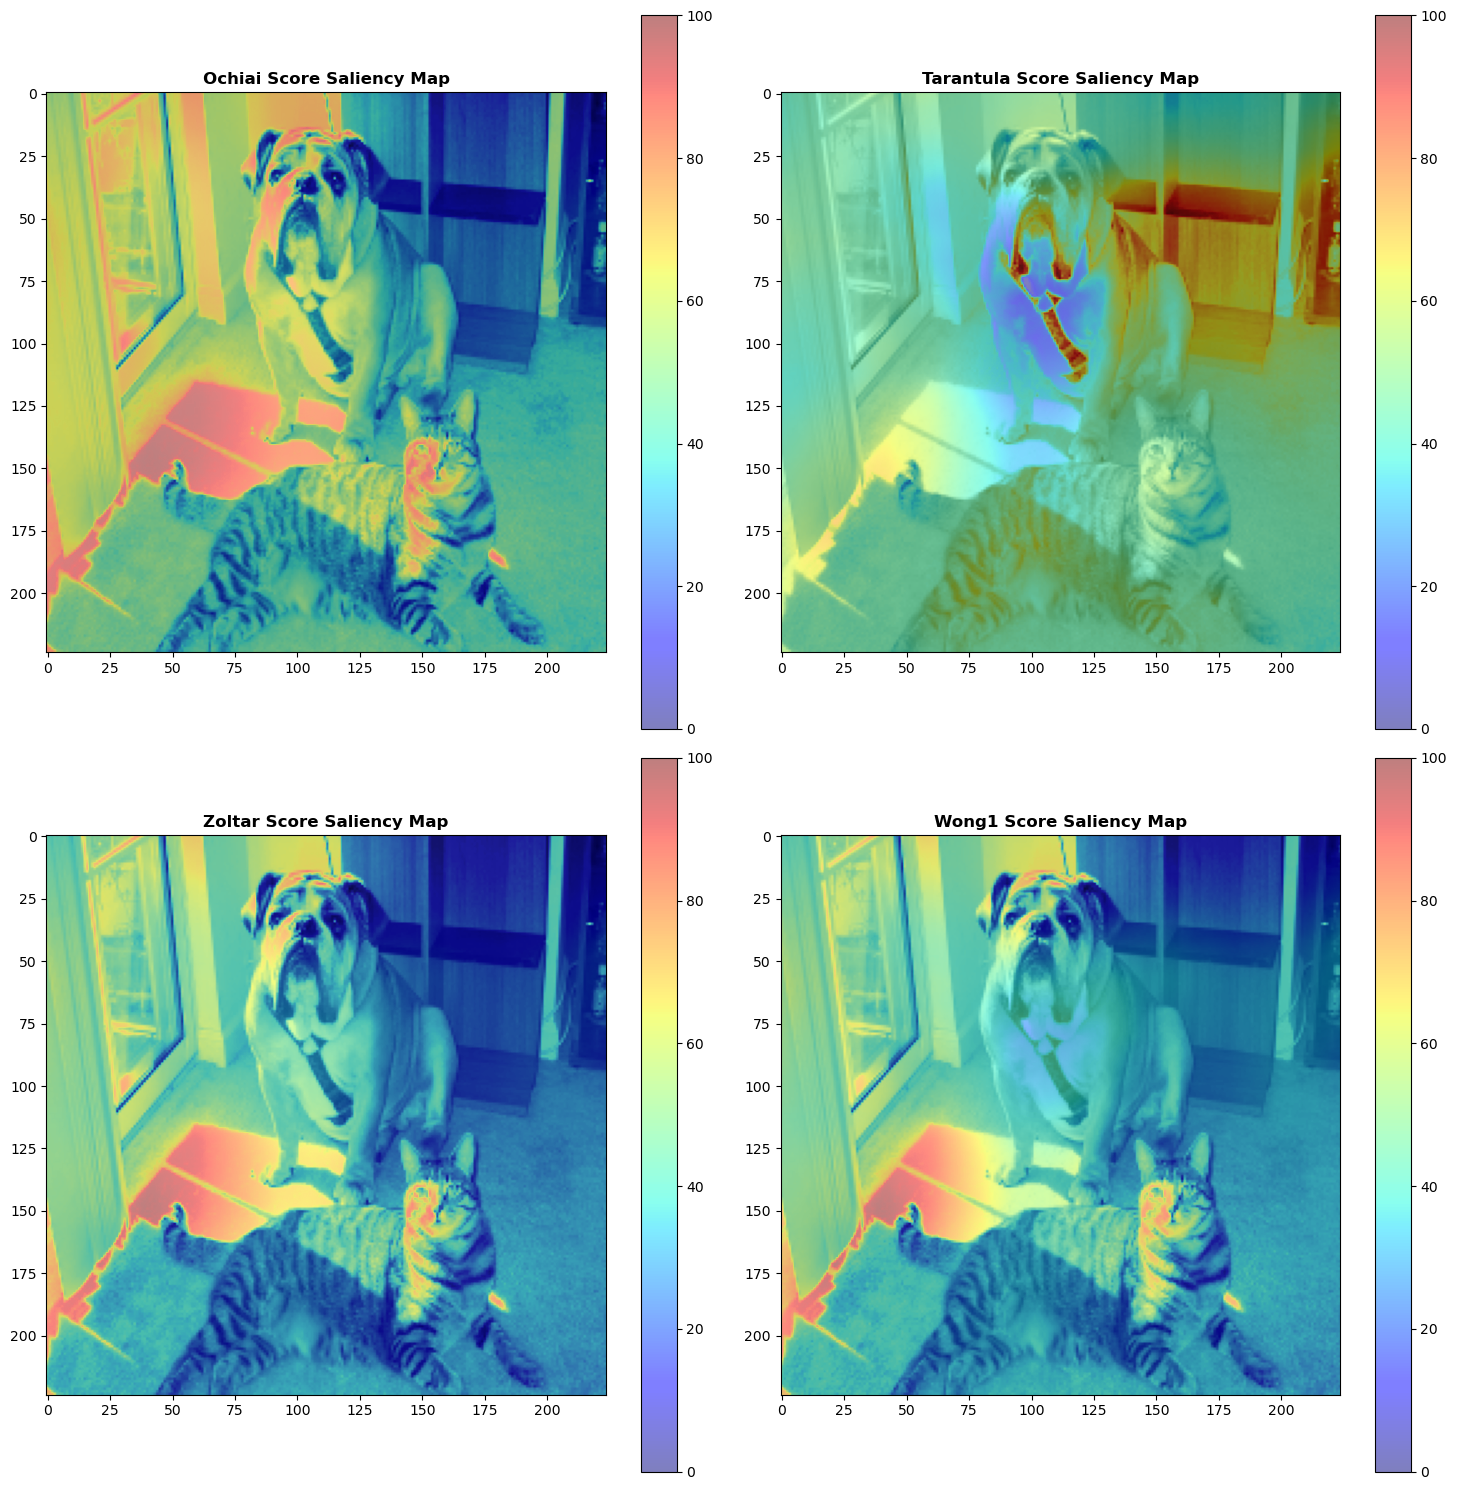

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Prepare the saliency maps
ochiai_map = mapped_ochiai_scores.reshape((224, 224))
tarantula_map = mapped_tarauntula_scores.reshape((224, 224))
zoltar_map = mapped_zoltar_scores.reshape((224, 224))
wong1_map = mapped_wong1_scores.reshape((224, 224))

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Define the extent
extent = [0, 224, 0, 224]

# List of maps and titles
maps = [ochiai_map, tarantula_map, zoltar_map, wong1_map]
titles = ['Ochiai Score Saliency Map', 'Tarantula Score Saliency Map', 'Zoltar Score Saliency Map', 'Wong1 Score Saliency Map']

# Plot each map
for ax, saliency_map, title in zip(axs.ravel(), maps, titles):
    # Display the original image
    ax.imshow(original_image_array, cmap='gray')
    
    # Overlay the saliency map
    c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)
    
    # Add a colorbar
    fig.colorbar(c, ax=ax)
    
    # Add title
    ax.set_title(title, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

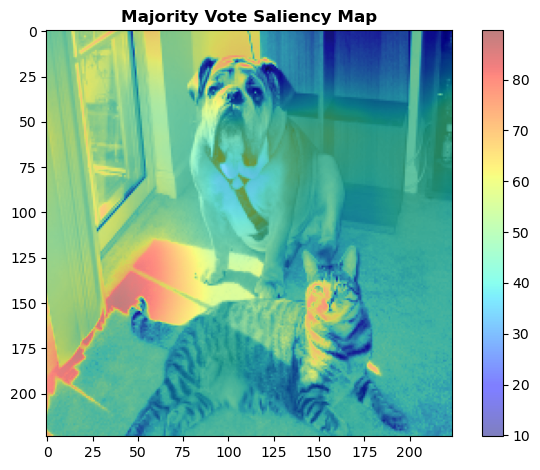

In [29]:

# Stack the scores for majority voting
all_scores = np.vstack((mapped_ochiai_scores, mapped_tarauntula_scores, mapped_wong1_scores)).T

# Function to get majority vote
def majority_vote(scores):
    return np.average(scores)# Apply majority voting

majority_scores = np.apply_along_axis(majority_vote, 1, all_scores)

# Apply majority voting
majority_scores = np.apply_along_axis(majority_vote, 1, all_scores)


# Reshape the majority scores to match the original image dimensions
saliency_map = majority_scores.reshape(original_image_array.shape)

# Plot the majority vote saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Majority Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

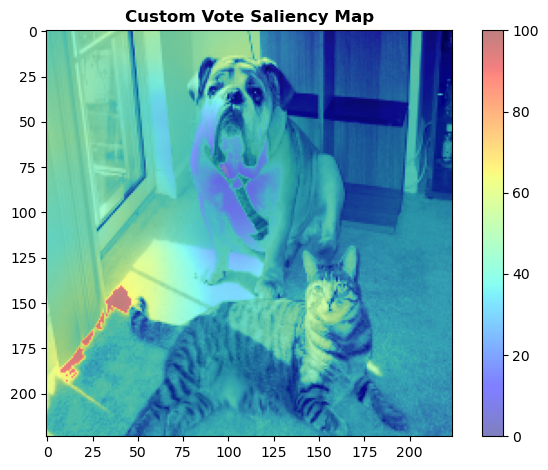

In [30]:
# Function to perform the custom voting logic
def custom_voting(scores):
    ochiai, tarantula, wong1 = scores
    
    # Prioritize low Ochiai values (below 25) if they are close to Zoltar
    if ochiai < 25:  # adjust the threshold as needed
            return ochiai
    
    # Prioritize high Tarantula and Wong values (80-100)
    if tarantula >= 65 and wong1 >= 60:
        return max(tarantula, wong1)
    
    # Default to the majority voting logic
    values, counts = np.unique(scores, return_counts=True)
    max_count = np.max(counts)
    if np.sum(counts == max_count) == 1:
        return values[np.argmax(counts)]
    else:
        return np.min(scores)

# Apply the custom voting to each pixel
custom_scores = np.apply_along_axis(custom_voting, 1, all_scores)

# Load and resize the original image, and convert to grayscale
 # Replace with your image path
original_image = Image.open(img_path).resize((224, 224)).convert('L')
original_image_array = np.array(original_image)

# Ensure the custom_scores array has the correct size
if custom_scores.size != original_image_array.size:
    raise ValueError(f"Size of custom_scores ({custom_scores.size}) does not match the original image size ({original_image_array.size})")

# Reshape the custom scores to match the original image dimensions
saliency_map = custom_scores.reshape(original_image_array.shape)

# Plot the custom vote saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Custom Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()